**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1C7fIw4owXEU7sMENvK6q45-BYLoWGjaT?usp=sharing)
2. Практический ноутбук

В первую очередь загрузите библиотеки. Большая часть из них – уже знакомые инструменты.

Рассмотрите подробнее **Activation** – слой, который позволяет отдельно задавать активационную функцию.

Если раньше писали `model.add(Dense(46, activation='relu'))`, то теперь можно написать `model.add(Dense(46))` и затем
`model.add(Activation('relu'))`.

Эти две записи равнозначны и работать они будут
одинаково.

In [1]:
# Библиотека работы с массивами
import numpy as np

# Библиотека для работы с таблицами
import pandas as pd

# Последовательная модель НС
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Слой задания активационной функции <----- !!!
from tensorflow.keras.layers import Activation

# Утилиты предобработки данных
from tensorflow.keras import utils

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Разделение на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split

# Рисование графиков
import matplotlib.pyplot as plt

%matplotlib inline

# Подготовка базы

## Загрузка и просмотр содержимого


Импортируйте библиотеку `gdown`, загрузите файл **sonar.csv** из репозитория при помощи метода `.download()`:

In [2]:
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/sonar.csv', None, quiet=True)

'sonar.csv'

Прочитайте и запишите его в переменную `df`, указывая, что в таблице нет заголовка `(header=None)`, выведите размерность датафрейма при помощи метода `.shape`:

In [3]:
df = pd.read_csv("sonar.csv", header=None)

print(df.shape)

(208, 61)


Выведите первые пять строчек таблицы, чтобы понимать, с какими данными придется работать:

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


В таблице вы увидите 61 столбец:
- первые 60 описывают параметры объекта
- последний 61-й содержит класс объекта (R – скала, M – мина).

Задача в том, чтобы научить нейросеть определять по параметрам, скала это или мина. Подобные задачи относятся к типу бинарной классификации.

## Парсинг





Перед тем как приступить к выполнению задания, давайте немного подготовим базу. Так как НС не работает с буквами, переведите все значения `R` и `M` в числа с плавающей точкой `1.` и `0.` соответственно:

In [5]:
dataset = df.replace('R', 1.).replace('M', 0.).astype(float).to_numpy()

Почему именно 1 и 0?

Вспомните, когда мы учили нейросеть определять цифры от 0 до 9 (на основе базы MNIST), последний выходной слой содержал 10 нейронов. Первый нейрон выдавал вероятность, что изображение относится к классу 0, второй что к классу 1 и пр. Это мультиклассовая классификация.

Бинарная классификация строится подобным же образом, но чуть проще. На первый взгляд, в текущей задаче  нужен выходной слой с двумя нейронами, первый выдает вероятность, что это мина, второй что это скала. Но можно обойтись и одним, т.к. если это не скала, то точно мина, других вариантов нет.

Если сеть выдает предсказание, что полученный объект на 40% процентов мина, само собой разумеется, что это на 60% скала, так как суммарная вероятность равна 1.

В `x_data` добавьте параметры объекта, в `y_data` – класс объекта (правильные ответы).

Способ разделения - срез (вариант 1 из ноутбука по теории):


In [6]:
x_data = dataset[:, :60]
y_data = dataset[:, 60]

Проверьте форму данных и содержимое `y_data`. В выборке всего `208` примеров.

In [7]:
print('Размерность набора параметров объектов', x_data.shape)
print('Размерность набора меток класса', y_data.shape)
print()
print('Содержание y_data:', y_data)

Размерность набора параметров объектов (208, 60)
Размерность набора меток класса (208,)

Содержание y_data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Создание обучающей и тестовой выборки


Чуть выше мы разделили весь массив данных на два набора: параметров объекта и соответствующих им меток классов. Пришло время разделить наборы на обучающую и тестовую выборки. Воспользуемся функцией `train_test_split` (см. теоретическую часть):

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

# Выведем размерность полученных выборок

print('Обучающая выборка параметров', x_train.shape)
print('Обучающая выборка меток классов', y_train.shape)
print()
print('Тестовая выборка параметров', x_test.shape)
print('Тестовая выборка меток классов', y_test.shape)

Обучающая выборка параметров (166, 60)
Обучающая выборка меток классов (166,)

Тестовая выборка параметров (42, 60)
Тестовая выборка меток классов (42,)


# Обучение нейросети

Напишем функцию сборки необученной модели нейронной сети. Это значит, что теперь нам не придется для создания еще одной модели заново прописывать все слои, достаточно будет вызвать функцию.

Первый слой НС – полносвязный на `60` нейронов, еще один слой на `30` нейронов, и последний слой на `1` нейрон.

В выходном слое используем функцию активации `sigmoid`, т.к. она преобразует вход в число от `0` до `1`.

Скомпилируйте НС и укажите `binary_crossentropy` в качестве функции ошибки, т.к. решается задача бинарной классификации:

In [8]:
def create_model():

    # Создание модели
    model = Sequential()

    # Добавление слоев
    model.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Компиляция и возврат модели
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


---

Дополнительная информация [База знаний | Функции активации | УИИ](https://colab.research.google.com/drive/1pGc7CFdrkKBhcXLqZNUzLXH4N83rRAl7?usp=sharing)

---
Дополнительная информация [База знаний | Функции ошибки | УИИ](https://colab.research.google.com/drive/1ZlmUDi7csXboFXwN22D_pLDYQcvJmt07?usp=sharing)

---

## Обучение модели

In [ ]:
# Создание необученной модели при помощи функции create_model()
model = create_model()

# Обучение модели
history = model.fit(x_train,       # Обучающая выборка параметров
          y_train,       # Обучающая выборка меток класса
          batch_size=8,  # Размер батча (пакета)
          epochs=100,    # Количество эпох обучения
          verbose=1)     # Отображение хода обучения

Epoch 1/100
21/21 [==============================] - 3s 4ms/step - loss: 0.6804 - accuracy: 0.6145
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 0.6571 - accuracy: 0.6265
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.6239 - accuracy: 0.6988
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5867 - accuracy: 0.7530
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5585 - accuracy: 0.7530
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.5160 - accuracy: 0.7892
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4962 - accuracy: 0.7590
Epoch 8/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4816 - accuracy: 0.7771
Epoch 9/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4407 - accuracy: 0.8072
Epoch 10/100
21/21 [==============================] - 0s 4ms/step - loss: 0.4267 - accuracy: 0.8313
Epoch 11/

## Оценка качества обучения

На тренировочной выборке НС достигает точности в **100%**. Приятная глазу цифра, но, к сожалению, не отражающая истинное положение дел.

Чтобы перепроверить нейросеть, а так же выяснить научилась она выявлять закономерности, или же просто заучила данные - создадим проверочную (валидационную) выборку.

In [ ]:
# Создание необученной модели при помощи функции create_model()
model = create_model()

# Обучение нейронной сети
history = model.fit(x_train,               # Обучающая выборка параметров
          y_train,               # Обучающая выборка меток класса
          batch_size=8,          # Размер батча (пакета)
          epochs=100,            # Количество эпох обучения
          validation_split=0.2,  # Доля проверочной выборки
          verbose=1)             # Отображение хода обучения

При запуске ячейки можно увидеть, что параметры процесса обучения изменились: добавилась информация о результатах предсказаний на проверочной выборке. Точность на проверочной выборке – **85%**.



Как теперь проходит обучение? После того, как НС прошла первую эпоху, вычислила ошибку и веса нейронов изменились, модель прогоняется на проверочной выборке и предсказывает результаты. На проверочной выборке НС не обучается. Затем начинается следующая эпоха обучения и процесс повторяется.

Применим метод `.evaluate()` к нашей модели, в качестве параметров передадим ему тестовые выборки и согласие на отображение хода вычисления. Поместим результат в переменную `scores`:

In [ ]:
scores = model.evaluate(x_test,
                        y_test,
                        verbose=1
                        )

2/2 [==============================] - 0s 6ms/step - loss: 0.4105 - accuracy: 0.7857


In [ ]:
print('Процент верных ответов на тестовых данных:', round(scores[1],2) * 100, '%')

Процент верных ответов на тестовых данных: 79.0 %


**Выводы:**

- `Точность на обучающей выборке` имеет самую низкую важность. Поскольку модели НС при обучении предъявляются и входные данные, и правильные ответы к ним, она может их просто зазубрить.

- `Точность на проверочной` важнее, так как её сеть видит только после окончания эпохи обучения и использует для проверки.

- `Точность на тестовой выборке` самая важная, так как она в процессе обучения в принципе не предъявляется модели.

## Визуализация качества обучения


Обучите НС, при этом результаты процесса обучения запишите в переменную **history**:

In [9]:
# Создание модели
model = create_model()

# Обучение нейронной сети
history = model.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=20,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/20
17/17 [==============================] - 2s 33ms/step - loss: 0.6922 - accuracy: 0.5379 - val_loss: 0.6880 - val_accuracy: 0.5000
Epoch 2/20
17/17 [==============================] - 0s 10ms/step - loss: 0.6591 - accuracy: 0.7424 - val_loss: 0.6627 - val_accuracy: 0.6471
Epoch 3/20
17/17 [==============================] - 0s 9ms/step - loss: 0.6387 - accuracy: 0.7727 - val_loss: 0.6409 - val_accuracy: 0.7353
Epoch 4/20
17/17 [==============================] - 0s 9ms/step - loss: 0.6153 - accuracy: 0.7273 - val_loss: 0.6351 - val_accuracy: 0.6471
Epoch 5/20
17/17 [==============================] - 0s 17ms/step - loss: 0.5870 - accuracy: 0.8030 - val_loss: 0.6368 - val_accuracy: 0.6176
Epoch 6/20
17/17 [==============================] - 0s 22ms/step - loss: 0.5565 - accuracy: 0.7803 - val_loss: 0.6118 - val_accuracy: 0.6765
Epoch 7/20
17/17 [==============================] - 0s 18ms/step - loss: 0.5343 - accuracy: 0.7803 - val_loss: 0.5978 - val_accuracy: 0.7059
Epoch 8/20
17/1

Постройте график точности на протяжении всего обучения.

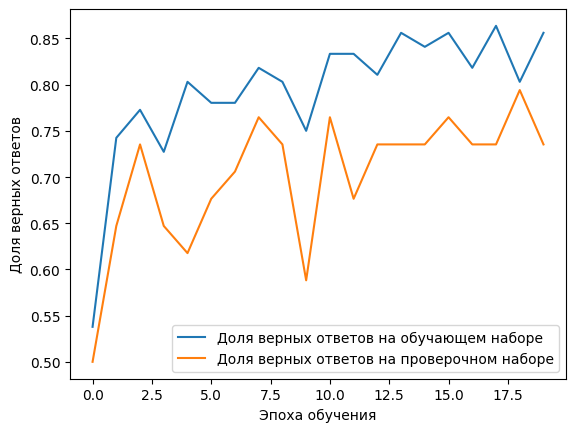

In [10]:
# Визуализация точности на обучающей выборке

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Сохранение диаграммы в файл
plt.savefig('accuracy.png')

# Вывод графика
plt.show()

На картинке можно видеть, что на последних эпохах точность на обучающей выборке достигла **100%**.

Также видно, что примерно на **30** эпохе обучения точность распознавания на проверочном наборе приблизилась к **85%**.

Теперь выведите график ошибки:

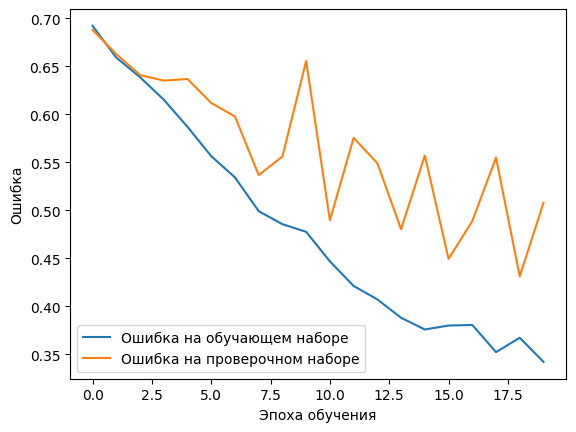

In [11]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')

plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

# Сохранение диаграммы в файл
plt.savefig('loss.png')

plt.show()

Последний график имеет большое значение для нейронщика. Если ошибка на обучающей выборке стремится к **0**, а на проверочной выборке снижается, но потом снова растет – это эффект переобучения. Примерно после **30** эпохи НС начинает заучивать ответы.

##Что делать с переобучением?

Попробуем решить проблему переобучения в исследуемой задаче.

### Слой  Dropout

Возьмите исходную архитектуру НС и добавьте слои `Dropout` (см. теоретическая часть):

In [ ]:
# Создание последовательной модели
model = Sequential()
model.add(Dropout(0.3, input_shape=(x_train.shape[1],)))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Обучение сети
history = model.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=200,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/200
17/17 [==============================] - 1s 16ms/step - loss: 0.6859 - accuracy: 0.5909 - val_loss: 0.6853 - val_accuracy: 0.5588
Epoch 2/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5985 - val_loss: 0.6790 - val_accuracy: 0.5882
Epoch 3/200
17/17 [==============================] - 0s 7ms/step - loss: 0.6625 - accuracy: 0.6136 - val_loss: 0.6787 - val_accuracy: 0.5882
Epoch 4/200
17/17 [==============================] - 0s 7ms/step - loss: 0.6799 - accuracy: 0.5379 - val_loss: 0.6634 - val_accuracy: 0.6471
Epoch 5/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6794 - accuracy: 0.6061 - val_loss: 0.6820 - val_accuracy: 0.6471
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.6977 - accuracy: 0.5606 - val_loss: 0.7432 - val_accuracy: 0.3824
Epoch 7/200
17/17 [==============================] - 0s 7ms/step - loss: 0.6302 - accuracy: 0.6364 - val_loss: 0.6855 - val_accuracy: 0.5588
Epoch 8/200


Результаты показывают, что даже после **200** эпох точность на обучающей выборке
остановилось на **85%**. Переобучения нет.

In [ ]:
# Краткая сводка архитектуры модели
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_9 (Dense)             (None, 60)                3660      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_10 (Dense)            (None, 30)                1830      
                                                                 
 dropout_2 (Dropout)         (None, 30)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 31        
                                                                 
Total params: 5,521
Trainable params: 5,521
Non-traina

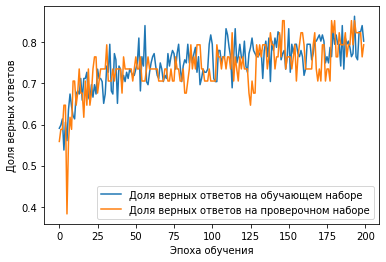

In [ ]:
# Отрисовка графика точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Отрисовка графика точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенду
plt.legend()

# Вывод графика
plt.show()

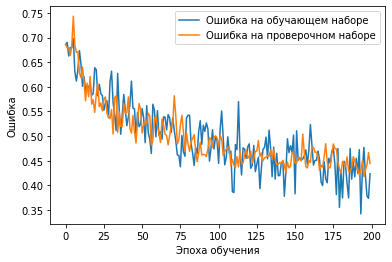

In [ ]:
# Вывод графика ошибки
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Оба графика подтверждают, что переобучения больше нет.

In [ ]:
# Вычисление результата (предсказания) сети на тестовом наборе
scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

2/2 [==============================] - 0s 7ms/step - loss: 0.3712 - accuracy: 0.9048
[0.37116172909736633, 0.9047619104385376]
Доля верных ответов на тестовых данных, в процентах: 90.4762%


---

Дополнительная информация [База знаний | Форматирование строк. Метод `.format()` | УИИ](https://colab.research.google.com/drive/1UiF-wgnFhlac6jnWLNqGmU93cHjtT6rI)

---

Теперь проверка НС на тестовом наборе показала, что точность выросла почти на **4%** и приблизилась к отметке в **90%**.

### Слой BatchNormalization


Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.7771 - accuracy: 0.5455 - val_loss: 0.6717 - val_accuracy: 0.7059
Epoch 2/100
1/1 [==============================] - 0s 36ms/step - loss: 0.7189 - accuracy: 0.5682 - val_loss: 0.6696 - val_accuracy: 0.6765
Epoch 3/100
1/1 [==============================] - 0s 38ms/step - loss: 0.6667 - accuracy: 0.6136 - val_loss: 0.6674 - val_accuracy: 0.6765
Epoch 4/100
1/1 [==============================] - 0s 61ms/step - loss: 0.6197 - accuracy: 0.6742 - val_loss: 0.6652 - val_accuracy: 0.6765
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 0.5775 - accuracy: 0.7121 - val_loss: 0.6630 - val_accuracy: 0.7059
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 0.5395 - accuracy: 0.7424 - val_loss: 0.6607 - val_accuracy: 0.7353
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.5055 - accuracy: 0.7652 - val_loss: 0.6582 - val_accuracy: 0.7647
Epoch 8/100
1/1 [=====

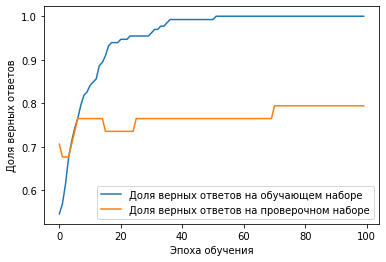

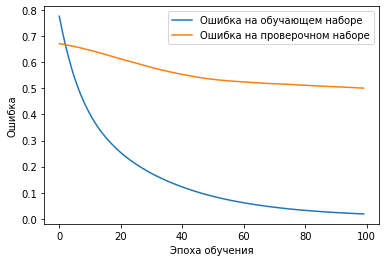

In [ ]:
model = Sequential()

model.add(BatchNormalization(input_shape=(x_train.shape[1], )))
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=200,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Как видите, результата почти никакого.

При этом на тестовой выборке результат очень сильно ухудшился. Возможно, стоит изменить архитектуру модели.

In [ ]:
# Вычисление результата (предсказания) сети на тестовом наборе

scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

2/2 [==============================] - 0s 8ms/step - loss: 0.6312 - accuracy: 0.5714
[0.6312006711959839, 0.5714285969734192]
Доля верных ответов на тестовых данных, в процентах: 57.1429%


### Совмещение Dropout и BatchNormalization

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.8218 - accuracy: 0.5682 - val_loss: 0.8021 - val_accuracy: 0.3235
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 0.8923 - accuracy: 0.5455 - val_loss: 0.7947 - val_accuracy: 0.3235
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 0.8757 - accuracy: 0.5682 - val_loss: 0.7879 - val_accuracy: 0.3235
Epoch 4/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6757 - accuracy: 0.5985 - val_loss: 0.7812 - val_accuracy: 0.3235
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 0.8155 - accuracy: 0.5303 - val_loss: 0.7745 - val_accuracy: 0.3235
Epoch 6/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6189 - accuracy: 0.6136 - val_loss: 0.7680 - val_accuracy: 0.3235
Epoch 7/100
1/1 [==============================] - 0s 35ms/step - loss: 0.6767 - accuracy: 0.6364 - val_loss: 0.7614 - val_accuracy: 0.3235
Epoch 8/100
1/1 [=====

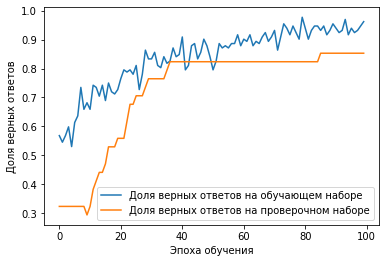

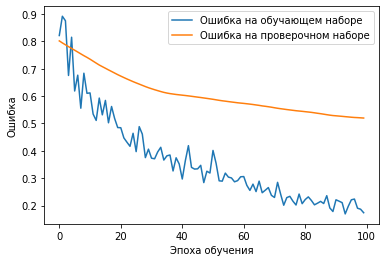

In [ ]:
model = Sequential()

model.add(Dense(60, activation='relu', input_shape=(x_train.shape[1], )))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=200,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [ ]:
# Вычисление результата (предсказания) сети на тестовом наборе

scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

2/2 [==============================] - 0s 8ms/step - loss: 0.5709 - accuracy: 0.6905
[0.5708683133125305, 0.6904761791229248]
Доля верных ответов на тестовых данных, в процентах: 69.0476%


Это не дало лучшего результата. Можно сделать вывод, что для изучаемых данных батч-нормализация больше вредна, чем полезна.

В этом и заключается работа нейронщика: подбирать необходимую архитектуру и проводить множество экспериментов для достижения наилучшего результата.

**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1C7fIw4owXEU7sMENvK6q45-BYLoWGjaT?usp=sharing)
2. Практический ноутбук